In [17]:
root_dir='./ABD+Coreset/outputs/LogitKD_no_ft/DFCIL-fivetask/CIFAR100/iscf/models/repeat-1/task-2'
# root_dir='./ABD+Coreset/outputs/AAAI2023/DFCIL-fivetask/CIFAR100/iscf/models/repeat-1/task-2/'

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import torch
from torchvision import transforms
from OrigianlABD.models.resnet import resnet32
# import gpytorch
# gpytorch.mlls.ExactMarginalLogLikelihood()

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if n > 0:
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = float(self.sum) / self.count

    def update_count(self, multiplier):
        self.count = self.count * multiplier
        self.avg = float(self.sum) / self.count

def scores_from_path(before_shuffle,save_path,post_shuffle=None):
        
    dataset_stats = {
        'CIFAR10' : {'mean': (0.49139967861519607, 0.48215840839460783, 0.44653091444546567),
                    'std' : (0.2470322324632819, 0.24348512800005573, 0.26158784172796434),
                    'size' : 32},
        'CIFAR100': {'mean': (0.5070751592371323, 0.48654887331495095, 0.4409178433670343),
                    'std' : (0.2673342858792409, 0.25643846291708816, 0.2761504713256834),
                    'size' : 32},   
        'ImageNet': {'mean': (0.485, 0.456, 0.406),
                    'std' : (0.229, 0.224, 0.225),
                    'size' : 224},      
        'TinyImageNet': {'mean': (0.4389, 0.4114, 0.3682),
                    'std' : (0.2402, 0.2350, 0.2268),
                    'size' : 64},  
                    }

    mean=dataset_stats['CIFAR100']['mean']
    std=dataset_stats['CIFAR100']['std']
    test_transforms=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
                                ])
    train_transforms=transforms.Compose([
                # transforms.RandomCrop(32, padding=4),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
                                ])


    def accuracy(output, target, topk=(1,)):
        """Computes the precision@k for the specified values of k"""
        with torch.no_grad():
            maxk = max(topk)
            batch_size = target.size(0)

            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].view(-1).float().sum().item()
                res.append(correct_k*100.0 / batch_size)

            if len(res)==1:
                return res[0]
            else:
                return res
    from torchvision import datasets
    dataset_path=os.path.join('../data/dataset/cifar100/')
    test_data = datasets.CIFAR100(root=dataset_path, train=False,
                                    download=False, transform=test_transforms)
    train_data = datasets.CIFAR100(root=dataset_path, train=True,
                                    download=False, transform=train_transforms)
    bsz=100
    subsets = {target: torch.utils.data.Subset(test_data, (np.array(test_data.targets)==target).nonzero()[0]) for target in range(100)}
    testloader = {target: torch.utils.data.DataLoader(subset,batch_size=bsz) for target, subset in subsets.items()}
    train_subsets = {target: torch.utils.data.Subset(train_data, (np.array(train_data.targets)==target).nonzero()[0]) for target in range(100)}
    trainloader = {target: torch.utils.data.DataLoader(subset,batch_size=bsz) for target, subset in train_subsets.items()}

    our_model=resnet32(100)
    our_model.load_state_dict(torch.load(os.path.join(root_dir,'class.pth'),map_location='cpu'))
    our_model.eval()
    our_model.to('cuda')

    # abd_model.load_state_dict(torch.load(abd_path+'class.pth'))
    #print("our model", tbd_model)
    import torch.nn as nn
    import torch.nn.functional as F
    y_true = []
    y_pred_abd = []
    y_pred_tbd = []
    m = nn.Softmax(dim=1)
    loss=nn.NLLLoss(reduction='none')
    # accs=AverageMeter()
    # dict_list={}
    accs=AverageMeter()
    inc=0

    logits=[]
    target_list=[]
    
    for i in range(100): #total class num
        # result = 0.0
        for batch_idx, (inputs, targets) in enumerate(trainloader[int(i)]):#NLL calcuate by same class group
            with torch.no_grad():
                inputs, targets = inputs.cuda(), targets.cuda()
                output_tbd = our_model(inputs)
                before_shuffle=before_shuffle.expand(output_tbd.shape[0],output_tbd.shape[1])
                outputs=torch.gather(output_tbd,1,before_shuffle)#indexing

                # outputs=m(outputs)
                logits.append(output_tbd.cpu())
                target_list.append(targets.cpu())


            acc = accuracy(outputs.detach(),targets)
            accs.update(acc,inputs.size(0))
        # dict_list[i]=result.item()
        print("\r{:3d}/{:3d} {:.2f}".format(inc,100,accs.avg),end='')
        inc+=1

    # for cls_idx in range(100):
    #     scores[cls_idx]=scores[cls_idx].sum
    logits=torch.cat(logits,dim=0)
    targets=torch.cat(target_list)
    return  logits,targets

In [18]:
post_shuffle=torch.tensor([23, 8, 11, 7, 48, 13, 1, 91, 94, 54, 16, 63, 52, 41, 80, 2, 47, 87, 78, 66, 19, 6, 24, 10, 59, 30, 22, 29, 83, 37, 93, 81, 43, 99, 86, 28, 34, 88, 44, 14, 84, 70, 4, 20, 15, 21, 31, 76, 57, 67, 73, 50, 69, 25, 98, 46, 96, 0, 72, 35, 58, 92, 3, 95, 56, 90, 26, 40, 55, 89, 75, 71, 60, 42, 9, 82, 39, 18, 77, 68, 32, 79, 12, 85, 36, 17, 64, 27, 74, 45, 61, 38, 51, 62, 65, 33, 5, 53, 97, 49]) # abds
before_list=[]
for xi in range(100):
    before_list.append((post_shuffle==xi).nonzero().item())
before_shuffle=torch.tensor(before_list).to('cuda').unsqueeze(0)


save_path=os.path.join(root_dir,'fakehkd')
if not os.path.exists(save_path):
    os.makedirs(save_path)
logits,targets=scores_from_path(before_shuffle,save_path,post_shuffle)
# arr2_DI=np.array(torch.tensor(scores).cpu().numpy()/1000000)#[before_list]

shuffled_indices=[]
for i in post_shuffle:
    mask=targets==i
    indices=(mask).nonzero().squeeze()
    shuffled_indices.append(indices)
shuffled_indices=torch.cat(shuffled_indices)
shuffled_logits=logits[shuffled_indices]

 99/100 33.80

In [8]:
print(shuffled_logits[00000:10000,00:20].norm(p=2,dim=1).mean(dim=0).item())
print(shuffled_logits[10000:20000,00:20].norm(p=2,dim=1).mean(dim=0).item())

# print(shuffled_logits[00000:10000,20:40].norm(p=2,dim=1).mean(dim=0).item())
# print(shuffled_logits[10000:20000,20:40].norm(p=2,dim=1).mean(dim=0).item())
# print(shuffled_logits[20000:30000,20:40].norm(p=2,dim=1).mean(dim=0).item())

# print(shuffled_logits[00000:10000,40:60].norm(p=2,dim=1).mean(dim=0).item())
# print(shuffled_logits[10000:20000,40:60].norm(p=2,dim=1).mean(dim=0).item())
# print(shuffled_logits[20000:30000,40:60].norm(p=2,dim=1).mean(dim=0).item())
# print(shuffled_logits[30000:40000,40:60].norm(p=2,dim=1).mean(dim=0).item())

# print(shuffled_logits[00000:10000,60:80].norm(p=2,dim=1).mean(dim=0).item())
# print(shuffled_logits[10000:20000,60:80].norm(p=2,dim=1).mean(dim=0).item())
# print(shuffled_logits[20000:30000,60:80].norm(p=2,dim=1).mean(dim=0).item())
# print(shuffled_logits[30000:40000,60:80].norm(p=2,dim=1).mean(dim=0).item())
# print(shuffled_logits[40000:50000,60:80].norm(p=2,dim=1).mean(dim=0).item())

20.467802047729492
20.636280059814453


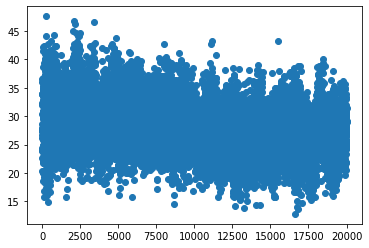

In [12]:

plt.figure()
plt.scatter(np.arange(0,20000),shuffled_logits[:20000,:20].norm(p=2,dim=1).cpu().numpy())
# plt.close()

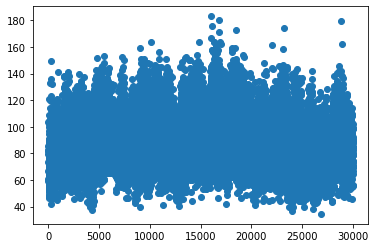

In [19]:
plt.figure()
plt.scatter(np.arange(0,30000),shuffled_logits[:20000,20:40].norm(p=1,dim=1).cpu().numpy())
# plt.close()

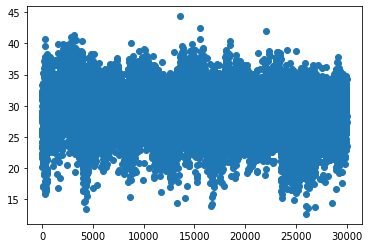

In [20]:
plt.figure()
plt.scatter(np.arange(0,30000),shuffled_logits[:20000,40:60].norm(p=1,dim=1).cpu().numpy())
# plt.close()

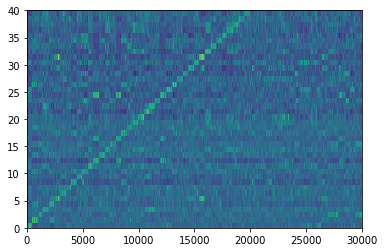

In [19]:
plt.pcolor(shuffled_logits[:30000,:40].transpose(0,1).numpy())


tensor([0.0459, 0.0460, 0.0503, 0.0224, 0.0422, 0.0160, 0.0440, 0.0383, 0.0499,
        0.0417, 0.0301, 0.0449, 0.0069, 0.0491, 0.0273, 0.0409, 0.0173, 0.0364,
        0.0274, 0.0342, 0.0083, 0.0084, 0.0149, 0.0087, 0.0783, 0.0062, 0.0119,
        0.0067, 0.0055, 0.0065, 0.0134, 0.0306, 0.0073, 0.0171, 0.0186, 0.0056,
        0.0104, 0.0051, 0.0149, 0.0103])
tensor([0.0025, 0.0012, 0.0025, 0.0081, 0.0007, 0.0033, 0.0030, 0.0036, 0.0013,
        0.0026, 0.0030, 0.0052, 0.0014, 0.0027, 0.0055, 0.0037, 0.0023, 0.0024,
        0.0063, 0.0015, 0.0473, 0.0464, 0.0424, 0.0469, 0.0463, 0.0466, 0.0473,
        0.0472, 0.0474, 0.0490, 0.0459, 0.0463, 0.0488, 0.0463, 0.0473, 0.0485,
        0.0472, 0.0479, 0.0462, 0.0459])
tensor([0.0242, 0.0096, 0.1086, 0.0089, 0.0016, 0.0108, 0.0180, 0.0152, 0.0236,
        0.0195, 0.0162, 0.0499, 0.0040, 0.0146, 0.0372, 0.0498, 0.0126, 0.0200,
        0.0139, 0.0148, 0.0606, 0.0063, 0.0062, 0.0309, 0.0409, 0.0590, 0.0124,
        0.0261, 0.0729, 0.0249, 0.0438

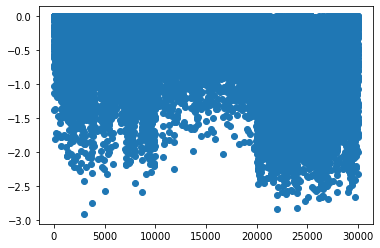

In [31]:
import torch.nn.functional as F
plt.figure()
# plt.yscale('log')
x=torch.softmax(shuffled_logits[:30000,:40],dim=1)
print(x[:10000].mean(dim=0))
print(x[10000:20000].mean(dim=0))
print(x[20000:30000].mean(dim=0))
plt.scatter(np.arange(0,30000),torch.sum(x*torch.log(x),dim=1).cpu().numpy())
# print(torch.sum(shuffled_logits[:30000,:40]*torch.log(shuffled_logits[:30000,:40]),dim=1).cpu().numpy())